## showing effect of pcs or peers on long range correlations

* remake tami's plots showing across chromosome correlations being removed with more pcs or peers

In [24]:
# import packages
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr, linregress
import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA



from residualize import calculate_residual

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Lung'

### load in data

expression and covariates

In [3]:
# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df_full = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')

covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

expression_df = expression_df_full.set_index('gene_id')[covariates_df.index]

In [4]:
# load in the gene information (start and strand are what I need)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]
full_gencode['gene_type'] = full_gencode['info'].str.split(';').str[2].str.split('\"').str[-2]
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])


gid_gencode = full_gencode.set_index('transcript_id').loc[expression_df.index]
gid_gencode = gid_gencode.drop_duplicates()

In [9]:
def two_part_residualize(expression_df, base_covariates_df, additional_covariates_df):
    full_covariates = pd.concat([base_covariates_df, additional_covariates_df], axis=1)
    # residulize the expression 
    residal_exp = calculate_residual(expression_df[full_covariates.index], full_covariates, center=True)
    residal_exp = pd.DataFrame(residal_exp, columns=full_covariates.index, index=expression_df.index)
    return residal_exp

In [8]:
# split out covatiates
base_covariates_df = covariates_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'pcr', 'platform', 'sex']]
peer_covariates_df = covariates_df[[f'InferredCov{i}' for i in range(1,61,1)]]

In [7]:
# get the genes from chr22 to plot
chr21_gene_ids = gid_gencode[gid_gencode['chr'] == 'chr21'].index.values

### residualize expression with different numbers of pcs or peers

In [10]:
def plot_heatmap_corr(corr, ax, cbar=True):
    # plot a heat map of correlations for increasing number of peer factors

    # mask so the off diagonal isn't shown
    mask = np.triu(np.ones_like(corr)) 
    # create the colormap, these are colors matched to the manhattenplots. coolwarm is another good option
    cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#c4553aff'), (.5, 'white'), (1, '#3e8093ff')])
    # plot the correlations
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation', 'pad':0}, xticklabels=True, yticklabels=True, cbar=cbar)

    # rotate the gene names
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # no axis labels
    ax.set_ylabel('')
    ax.set_xlabel('')


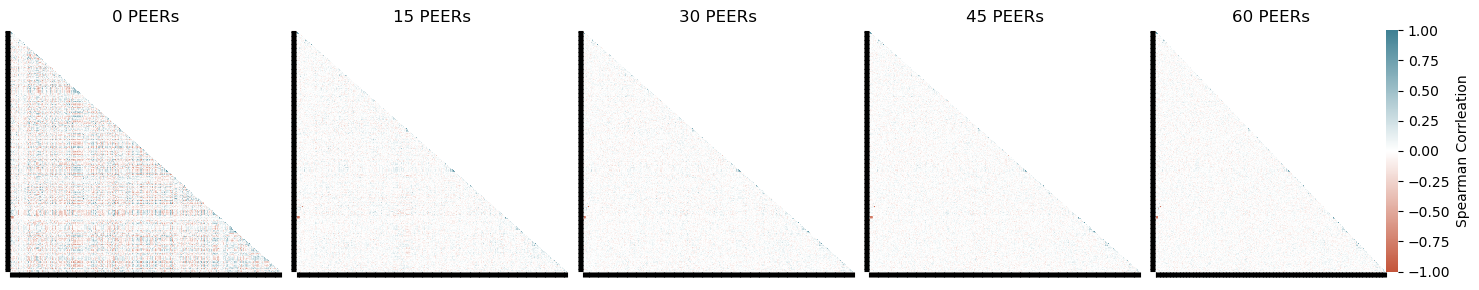

In [45]:
# correlation plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    plot_heatmap_corr(sub_corr, axes[i], cbar=True if i==4 else False)


fig.tight_layout()


In [33]:
# by decile of gene-gene distance

# matrix of gene-gene distances
start_positions = gid_gencode.loc[chr21_gene_ids]['tss_start'].values
dist_matrix = np.abs(start_positions[:, None] - start_positions)

# Create deciles based on distance 
deciles = np.percentile(dist_matrix, [10, 20, 30, 40, 50, 60, 70, 80, 90])
decile_df = pd.DataFrame(np.digitize(dist_matrix, deciles), index=chr21_gene_ids, columns=chr21_gene_ids)

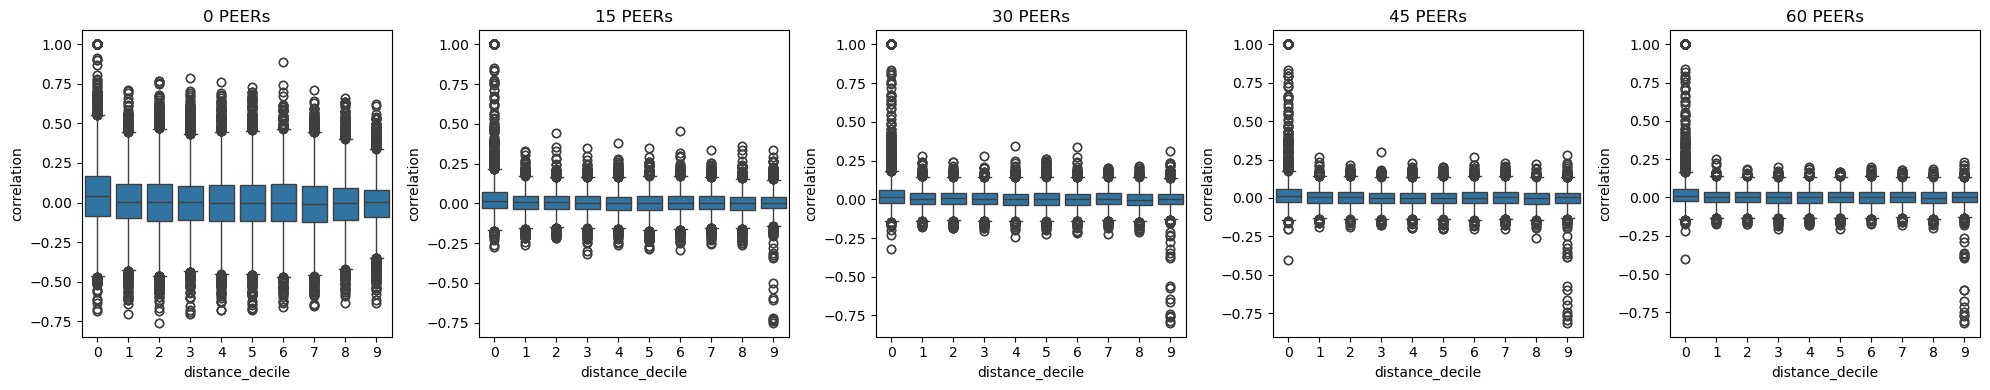

In [49]:
# correlation plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} PEERs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, peer_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

#### pca factors

In [41]:
# get pc covariantes (these will be cacluated after the genotype pc and other base covars are residualized)

base_residual_expression = calculate_residual(expression_df[base_covariates_df.index], base_covariates_df, center=True)
base_residual_expression = pd.DataFrame(base_residual_expression, columns=base_covariates_df.index, index=expression_df.index)

# get global pcs 
pca = PCA()
global_pc_values = pca.fit_transform(base_residual_expression)
pc_covariates_df = pd.DataFrame(global_pc_values.T, index=covariates_df.index, columns=[f'PC{i}' for i in range(global_pc_values.shape[0])])


In [42]:
slope, intercept, r_value, p_value, std_err = linregress(pc_covariates_df.iloc[:,0], base_residual_expression.iloc[0])
r_value

0.011812097049206617

<AxesSubplot: xlabel='distance_decile', ylabel='correlation'>

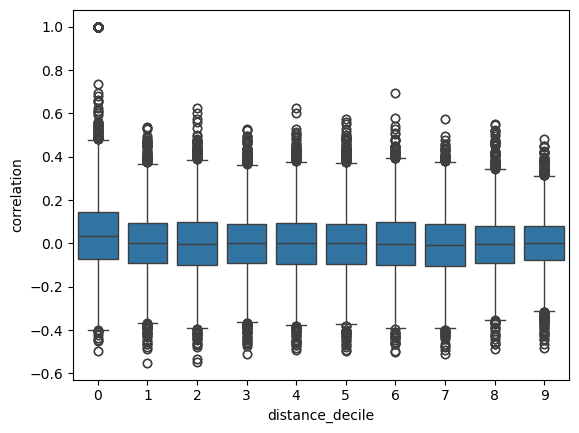

In [43]:
# get corr with this many peerspeer_covariates_df
sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df)
sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile')

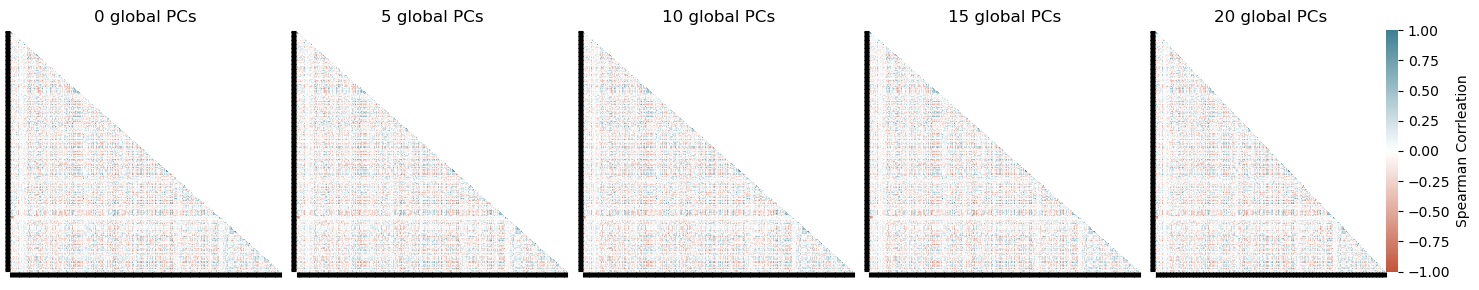

In [85]:
# correlation plots by increaseing global pc factor count

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].set_title(f'{5*i} global PCs')

    # get corr with this many global pcs residualized
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    plot_heatmap_corr(sub_corr, axes[i], cbar=True if i==4 else False)


fig.tight_layout()


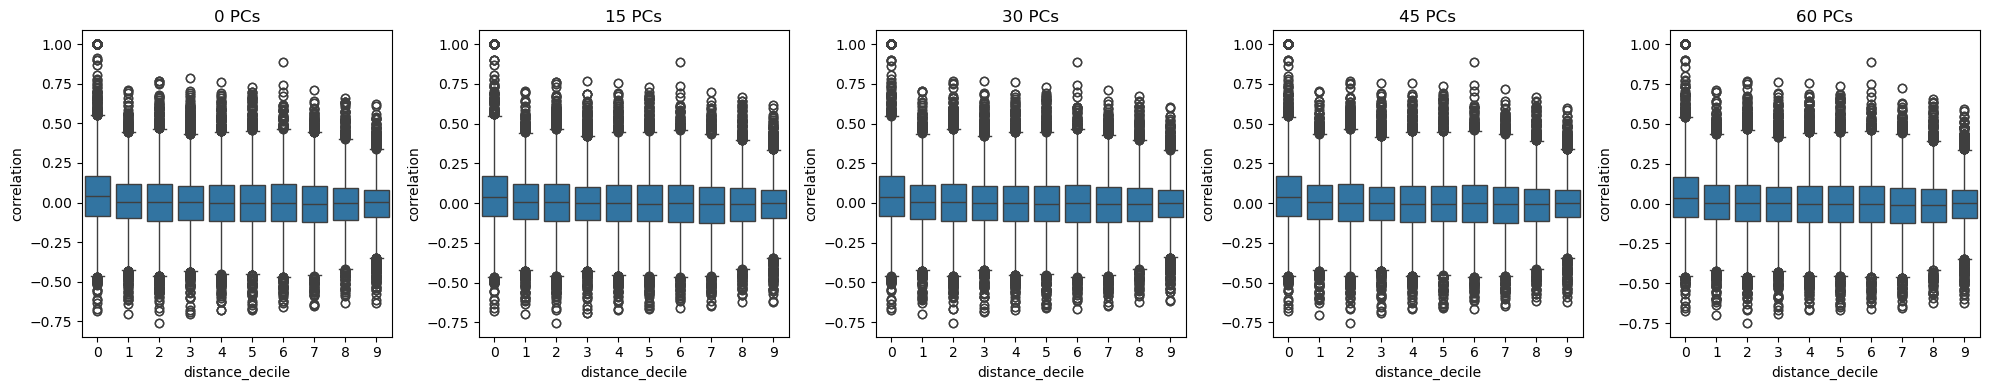

In [76]:
# correlation plots by increaseing peer factor count

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].set_title(f'{15*i} PCs')

    # get corr with this many peerspeer_covariates_df
    sub_exp = two_part_residualize(expression_df, base_covariates_df, pc_covariates_df.iloc[:, :15*i])
    sub_corr = sub_exp.loc[chr21_gene_ids].T.corr(method='spearman')
    distance_split_corr_df = pd.DataFrame([pd.Series(sub_corr.values[decile_df==i], name=i) for i in range(10)]).T.melt(var_name='distance_decile', value_name='correlation')
    sns.boxplot(distance_split_corr_df, y='correlation', x='distance_decile', ax=axes[i])

fig.tight_layout()

<AxesSubplot: xlabel='distance_decile', ylabel='correlation'>

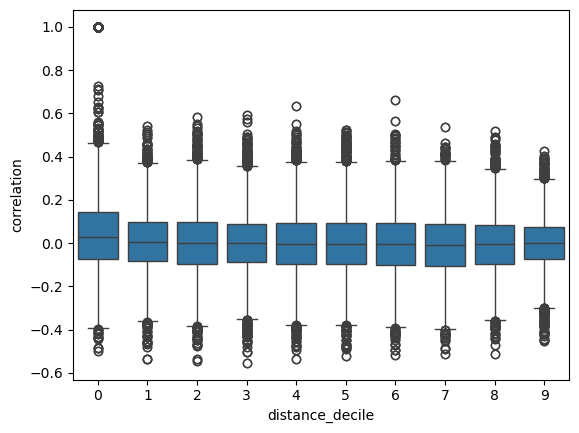